# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import optuna
from optuna.samplers import TPESampler
import warnings
import shap
warnings.filterwarnings("ignore")

# Loading the Dataset

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")
#Original Dataset
original = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')
original['Depression'] = original['Depression'].map({"Yes": 1, "No": 0})

# Understanding the Data

In [3]:
train.shape

(140700, 20)

In [4]:
train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [5]:
train.columns

Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [7]:
train.isnull().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [8]:
train.shape

(140700, 20)

In [9]:
original.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,0
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,0
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,0
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,0
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,0


In [10]:
original.shape

(2556, 19)

In [11]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   2556 non-null   object 
 1   Gender                                 2556 non-null   object 
 2   Age                                    2556 non-null   int64  
 3   City                                   2556 non-null   object 
 4   Working Professional or Student        2556 non-null   object 
 5   Profession                             1883 non-null   object 
 6   Academic Pressure                      502 non-null    float64
 7   Work Pressure                          2054 non-null   float64
 8   CGPA                                   502 non-null    float64
 9   Study Satisfaction                     502 non-null    float64
 10  Job Satisfaction                       2054 non-null   float64
 11  Slee

# 4. Data Visualization

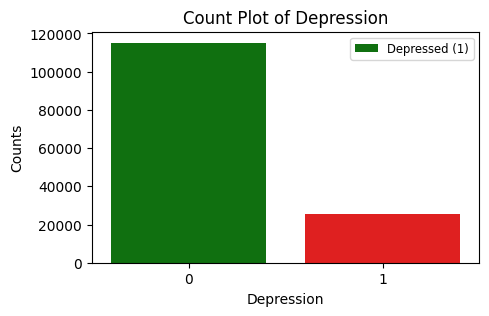

In [12]:
plt.figure(figsize = (5,3))
sns.countplot(data=train ,x = "Depression",palette={0: "green", 1: "red"})
plt.title("Count Plot of Depression")
plt.legend( loc ="upper right", labels =['Depressed (1)','Normal(0)'],fontsize='small')
plt.xlabel("Depression")
plt.ylabel("Counts")
plt.show()

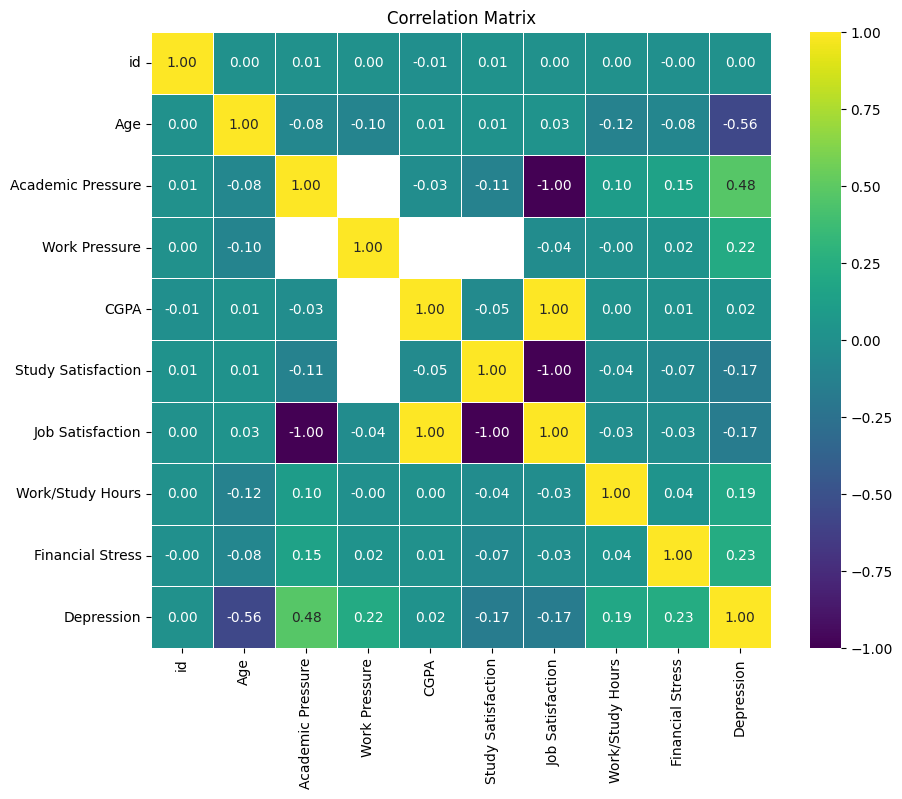

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Computing the correlation matrix
corr_matrix = train.select_dtypes(np.number).corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Numerical Columns

In [14]:
numerical_cols = train.select_dtypes(include = ['number']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ["id",'Depression']]
numerical_cols

['Age',
 'Academic Pressure',
 'Work Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Work/Study Hours',
 'Financial Stress']

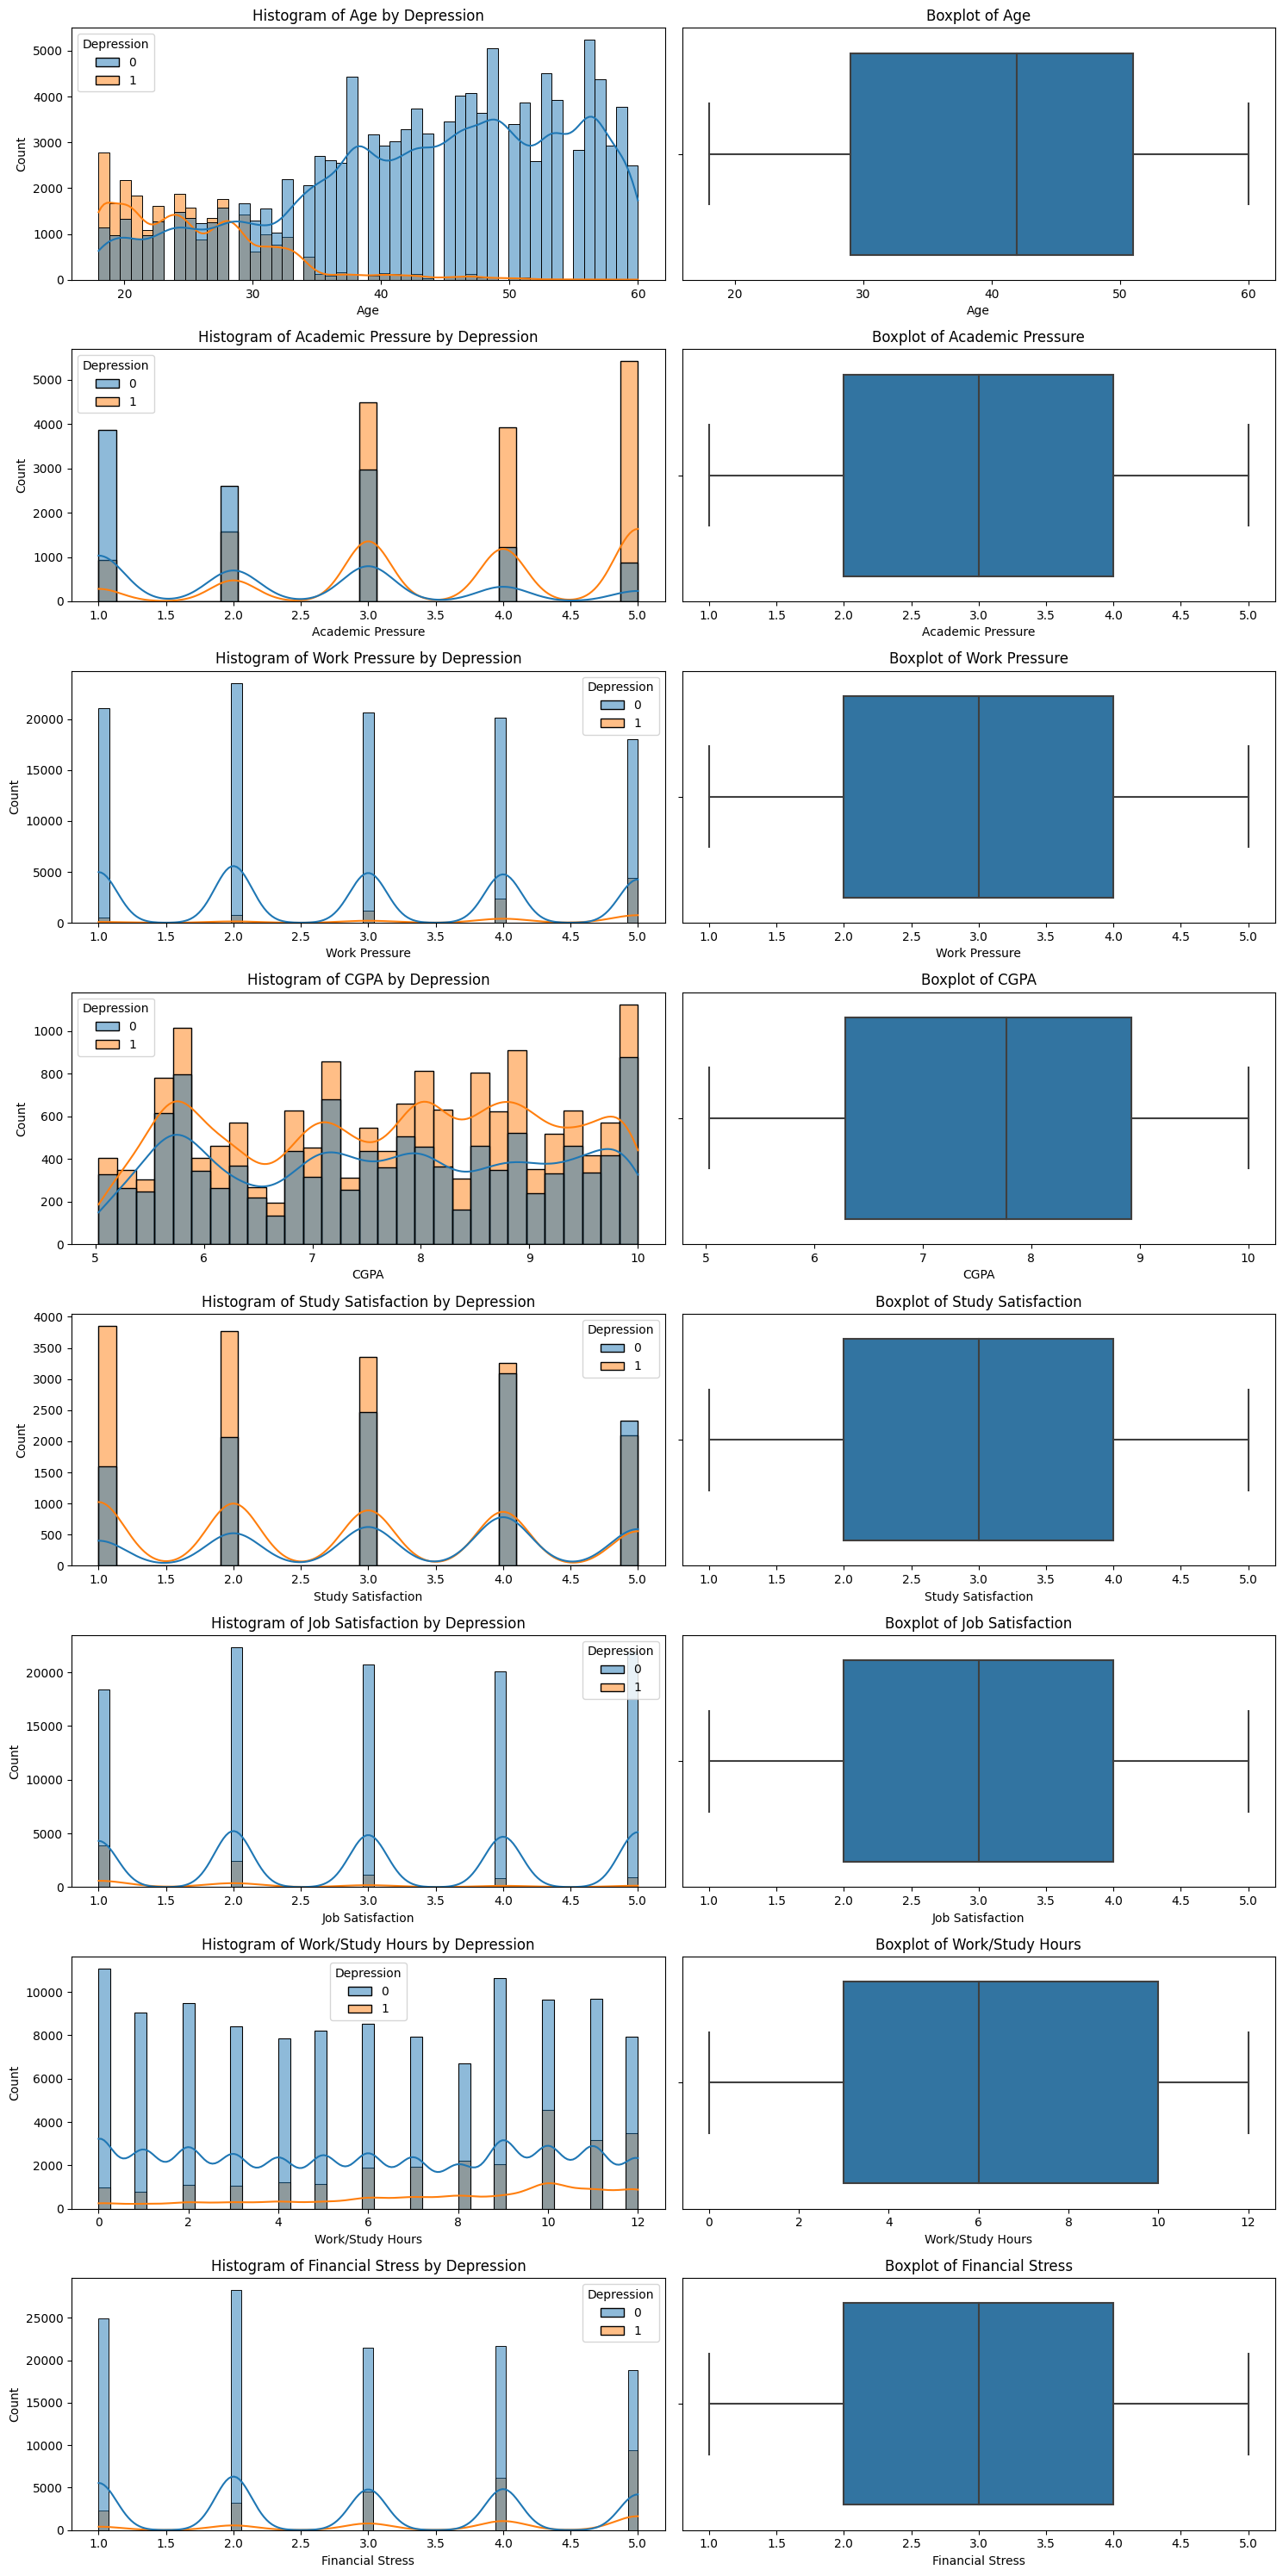

In [15]:
fig, axs = plt.subplots(len(numerical_cols), 2, figsize = (15,30))

for i, col in enumerate(numerical_cols) :
    
    sns.histplot(data = train, x = col, hue = 'Depression',kde=True,ax=axs[i,0])
    axs[i,0].set_title(f'Histogram of {col} by Depression')
    
    sns.boxplot(data = train, x = col, ax= axs[i,1])
    axs[i,1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

## Categorical Columns

In [16]:
train['Sleep Duration']

0         More than 8 hours
1         Less than 5 hours
2                 5-6 hours
3         Less than 5 hours
4                 5-6 hours
                ...        
140695            5-6 hours
140696            7-8 hours
140697    More than 8 hours
140698            5-6 hours
140699    Less than 5 hours
Name: Sleep Duration, Length: 140700, dtype: object

In [17]:
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Name',]]
categorical_cols

['Gender',
 'City',
 'Working Professional or Student',
 'Profession',
 'Sleep Duration',
 'Dietary Habits',
 'Degree',
 'Have you ever had suicidal thoughts ?',
 'Family History of Mental Illness']

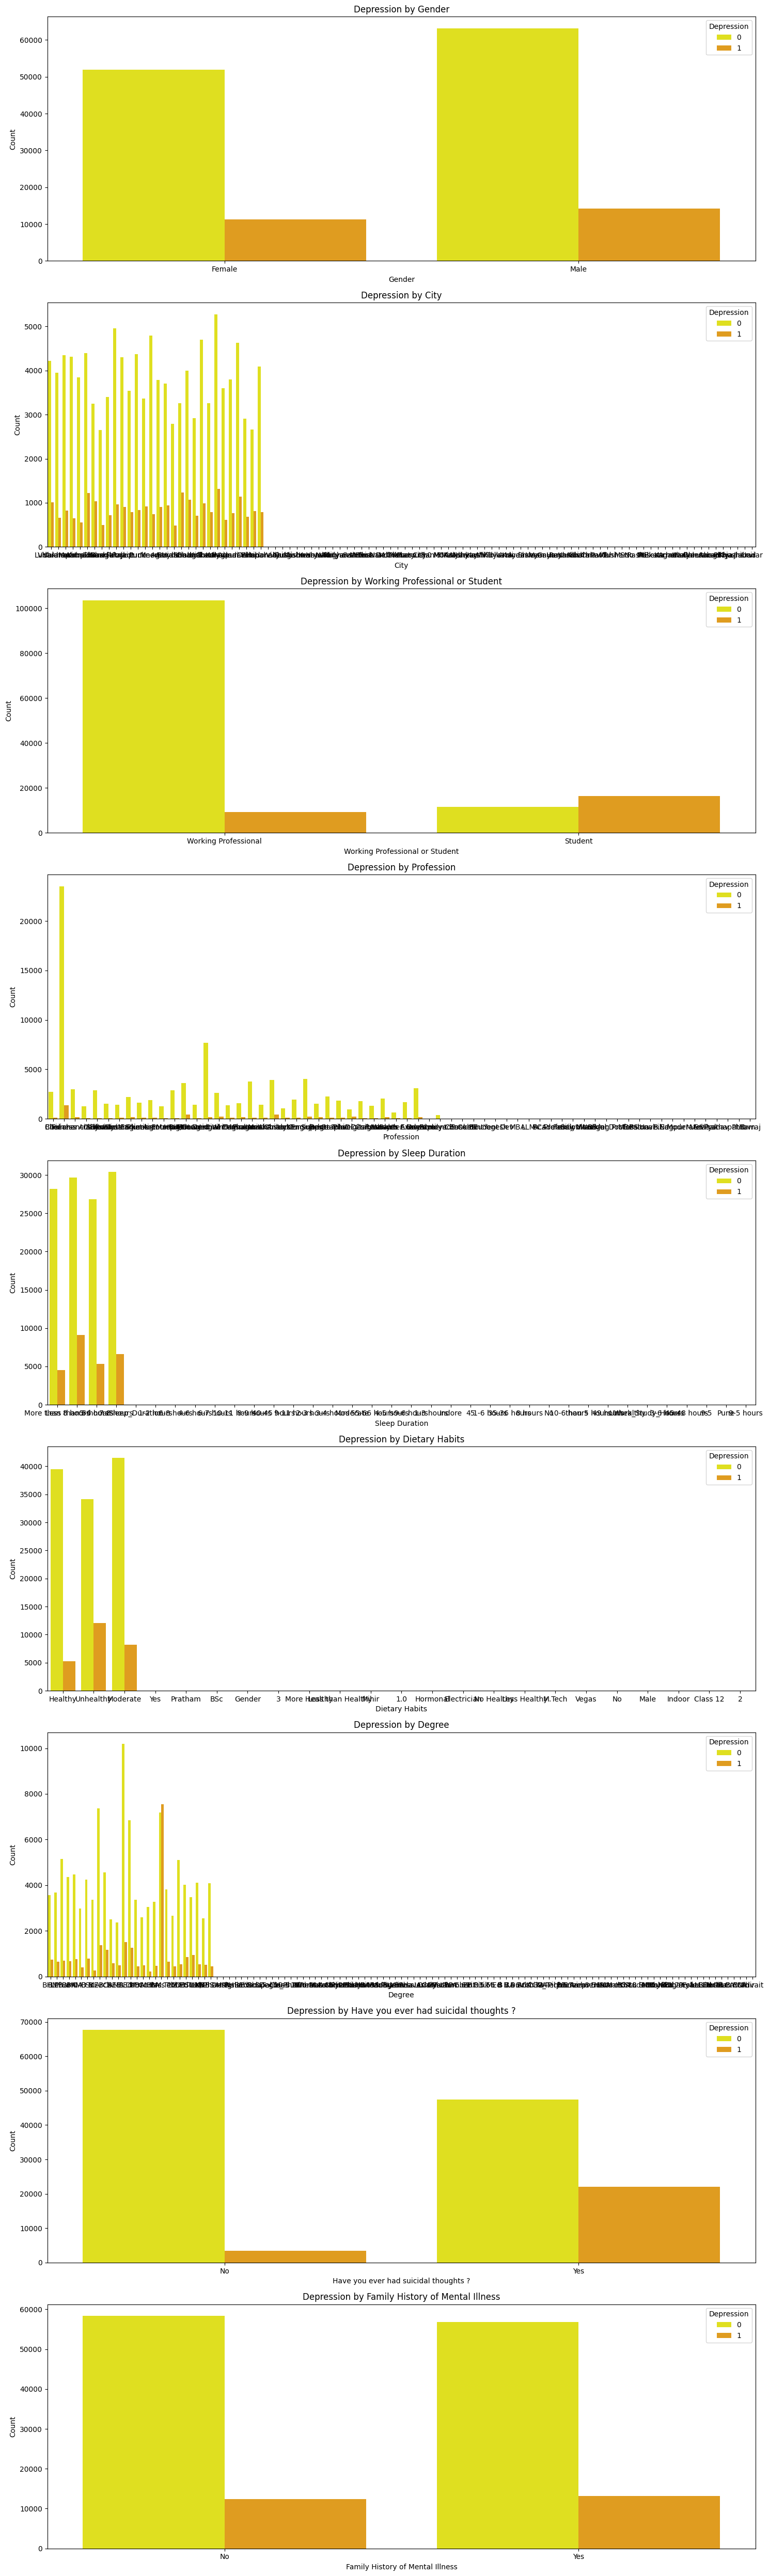

In [18]:
fig,axs = plt.subplots(len(categorical_cols),1,figsize=(15,50))
palette = {0: 'yellow', 1: 'orange'}
for i,col in enumerate(categorical_cols):

    sns.countplot(data = train, x = train[col], hue = 'Depression',palette = palette,ax=axs[i])
    axs[i].set_title(f'Depression by {col}')
    axs[i].set_xlabel(f'{col}')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Exploratory Data Analysis

## Fixing the "Sleep Duration" Column

In [19]:
train["Sleep Duration"].unique()

array(['More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours',
       'Sleep_Duration', '1-2 hours', '6-8 hours', '4-6 hours',
       '6-7 hours', '10-11 hours', '8-9 hours', '40-45 hours',
       '9-11 hours', '2-3 hours', '3-4 hours', 'Moderate', '55-66 hours',
       '4-5 hours', '9-6 hours', '1-3 hours', 'Indore', '45', '1-6 hours',
       '35-36 hours', '8 hours', 'No', '10-6 hours', 'than 5 hours',
       '49 hours', 'Unhealthy', 'Work_Study_Hours', '3-6 hours',
       '45-48 hours', '9-5', 'Pune', '9-5 hours'], dtype=object)

In [20]:
sleep_duration_mapping={
        "More than 8 hours":9,
        'Less than 5 hours':4,
        '5-6 hours':5.5,
        '7-8 hours':7.5,
        '1-2 hours':1.5,
        '6-8 hours':7,
        '4-6 hours':5,
        '6-7 hours':6.5,
        '10-11 hours':10.5,
        '8-9 hours':8.5,
        '9-11 hours':10,
        '2-3 hours':2.5,
        '3-4 hours':3.5,
        'Moderate':6,
        '4-5 hours':4.5,
        '9-6 hours':7.5,
        '1-3 hours':2,
        '1-6 hours':4,
        '8 hours':8,
        '10-6 hours':8,
        'Unhealthy':3,
        'Work_Study_Hours':6,
        '3-6 hours':3.5,
        '9-5':7,
        '9-5 hours':7,
}

In [21]:
# Apply the mapping and set others to NaN
train['Sleep Duration'] = train['Sleep Duration'].map(sleep_duration_mapping).fillna(np.nan)
test['Sleep Duration'] = test['Sleep Duration'].map(sleep_duration_mapping).fillna(np.nan)

original['Sleep Duration'] = original['Sleep Duration'].map(sleep_duration_mapping).fillna(np.nan)

## NAN Values

In [22]:
# Working Professional or Student 
''' 
1 . For all where 'Working Professional or Student' is "Student" then 
fill the corresponding value in "Profession" as "Student

2. Fill the rest of the NAN Values in 'Profession' as 'Other'

"'''
train.loc[train['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
train['Profession'] = train['Profession'].fillna('Other')

test.loc[test['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
test['Profession'] = test['Profession'].fillna('Other')

 
original.loc[original['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
original['Profession'] = original['Profession'].fillna('Other')

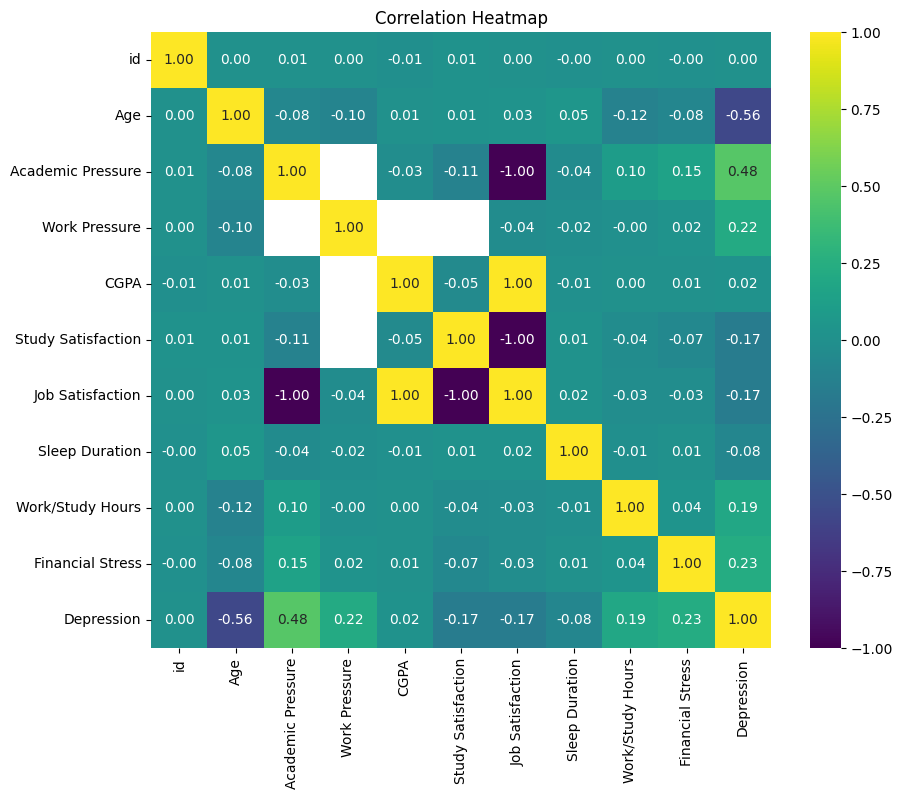

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = train.select_dtypes(include=np.number).corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis", cbar=True)

# Add a title
plt.title("Correlation Heatmap")
plt.show()

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             140700 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [25]:
def merge(df):
    df['Satisfaction'] = df['Job Satisfaction'].fillna(df['Study Satisfaction'])
    df['Pressure'] = df['Academic Pressure'].fillna(df['Work Pressure'])
    df.drop(columns= ['Job Satisfaction','Study Satisfaction','Academic Pressure','Work Pressure'],inplace =True )
    
    return df 

train = merge(train)
test = merge(test)
original = merge(original)

In [26]:
print("Train Null Values")
print(train.isnull().sum())
print("****************")
print("Test Null Values")
print(test.isnull().sum())
print("****************")
print("Original Null Values")
print(original.isnull().sum())

Train Null Values
id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                    0
CGPA                                     112802
Sleep Duration                               16
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
Satisfaction                                 15
Pressure                                     21
dtype: int64
****************
Test Null Values
id                                           0
Name                    

In [27]:
train.Degree.unique()

array(['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'BSc', 'ME', 'B.Arch',
       'BCA', 'BE', 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com', 'MHM', 'BA',
       'Class 12', 'M.Tech', 'PhD', 'M.Ed', 'MSc', 'B.Tech', 'LLM',
       'MBBS', 'M.Pharm', 'UX/UI Designer', 'MPA', 'BH', 'Nalini', 'BEd',
       'B.Sc', 'Veda', 'Bhopal', 'S.Tech', 'Degree', '20', 'Class 11',
       'H_Pharm', 'M', 'P.Com', 'BPharm', 'Business Analyst', 'M.Arch',
       'LL.Com', 'Data Scientist', 'MPharm', 'L.Ed', 'P.Pharm', 'Kalyan',
       'Unite', 'BArch', 'HR Manager', 'Badhya', 'S.Pharm', 'LLBA',
       'Vrinda', 'M. Business Analyst', 'Bhavesh', '0', 'LLCom', '29',
       'MTech', 'Vivaan', 'BPA', 'Plumber', '5.61', 'Brit', 'B.03',
       'Ritik', '5.56', 'MEd', 'B', 'B BA', '7.06', 'B.B.Arch', 'ACA',
       'Brithika', 'CGPA', '24', 'M_Tech', 'Pihu', 'BB', 'Jhanvi',
       'LLTech', 'Aarav', 'Entrepreneur', '8.56', 'LHM', 'Lata', 'S.Arch',
       'Marsh', 'HCA', '5.88', 'B.Student', 'LL B.Ed', 'M.S', 'Navya',
   

In [28]:
degree = {
    "BCom": "B.Com", "B.Com": "B.Com", "B.Comm": "B.Com",
    "B.Tech": "B.Tech", "BTech": "B.Tech", "B.T": "B.Tech",
    "BSc": "B.Sc", "B.Sc": "B.Sc", "Bachelor of Science": "B.Sc",
    "BArch": "B.Arch", "B.Arch": "B.Arch",
    "BA": "B.A", "B.A": "B.A",
    "BBA": "BBA", "BB": "BBA",
    "BCA": "BCA",
    "BE": "BE",
    "BEd": "B.Ed", "B.Ed": "B.Ed",
    "BPharm": "B.Pharm", "B.Pharm": "B.Pharm",
    "BHM": "BHM",
    "LLB": "LLB", "LL B": "LLB", "LL BA": "LLB", "LL.Com": "LLB", "LLCom": "LLB",
    "MCom": "M.Com", "M.Com": "M.Com",
    "M.Tech": "M.Tech", "MTech": "M.Tech", "M.T": "M.Tech",
    "MSc": "M.Sc", "M.Sc": "M.Sc", "Master of Science": "M.Sc",
    "MBA": "MBA",
    "MCA": "MCA",
    "MD": "MD",
    "ME": "ME",
    "MEd": "M.Ed", "M.Ed": "M.Ed",
    "MArch": "M.Arch", "M.Arch": "M.Arch",
    "MPharm": "M.Pharm", "M.Pharm": "M.Pharm",
    "MA": "MA", "M.A": "MA",
    "MPA": "MPA",
    "LLM": "LLM",
    "PhD": "PhD",
    "MBBS": "MBBS",
    "CA": "CA",
    "Class 12": "Class 12", "12th": "Class 12",
    "Class 11": "Class 11", "11th": "Class 11"
}

train['Degree'] = train['Degree'].map(degree)
test['Degree'] = test['Degree'].map(degree)
original['Degree'] = original['Degree'].map(degree)

train.fillna({'Degree': 'Unknown'}, inplace=True)
test.fillna({'Degree': 'Unknown'}, inplace=True)
original.fillna({'Degree': 'Unknown'}, inplace=True)

train['Degree'].unique()

array(['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'B.Sc', 'ME',
       'B.Arch', 'BCA', 'BE', 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com',
       'Unknown', 'B.A', 'Class 12', 'M.Tech', 'PhD', 'M.Ed', 'M.Sc',
       'B.Tech', 'LLM', 'MBBS', 'M.Pharm', 'MPA', 'Class 11', 'M.Arch'],
      dtype=object)

In [29]:
train.columns

Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'CGPA',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression',
       'Satisfaction', 'Pressure'],
      dtype='object')

In [30]:
# Dietaggary Noise

diet={
    'More Healty':0,
    'Healthy':1,
    'Less than Healthy':2,
    'Less Healthy':2,
    'Moderate':3,
    'Unhealthy':4,   
    'No Healthy':4,
}

train['Dietary Habits'] = train['Dietary Habits'].map(diet)
test['Dietary Habits'] = test['Dietary Habits'].map(diet)
original['Dietary Habits'] = original['Dietary Habits'].map(diet)

train['Dietary Habits'].unique()

array([ 1.,  4.,  3., nan,  2.])

In [31]:
train['Dietary Habits'].isnull().sum()

24

In [32]:
# CITY Noise
def city_noise(df):
    # Get the value counts for the 'City' column
    city_counts = df['City'].value_counts()

    # Create a list of cities with count less than 100
    cities_to_replace = city_counts[city_counts < 100].index

    # Replace cities with counts less than 100 with 'Other'
    df['City'] = df['City'].apply(lambda x: 'Other_Cities' if x in cities_to_replace else x)
    
    return df

train = city_noise(train)
test = city_noise(test)
original = city_noise(original)

In [33]:
# Profession Noise
def profession_noise(df):

    profession_counts = df['Profession'].value_counts()

    # Create a list of profession with count less than 100
    profession_to_replace = profession_counts[profession_counts < 100].index

    # Replace with counts less than 100 with 'Other'
    df['Profession'] = df['Profession'].apply(lambda x: 'Unknown_Profession' if x in profession_to_replace else x)
    
    return df

train = profession_noise(train)
test = profession_noise(test)
original= profession_noise(original)

In [34]:
train.isnull().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                    0
CGPA                                     112802
Sleep Duration                               16
Dietary Habits                               24
Degree                                        0
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
Satisfaction                                 15
Pressure                                     21
dtype: int64

In [35]:
#Checking Noise Columns

noise_cols = ["City", "Profession","Dietary Habits", "Degree"]

for col in noise_cols:
    print(train[col].value_counts())
    print(test[col].value_counts())
    print(original[col].value_counts())

City
Kalyan           6591
Patna            5924
Vasai-Virar      5765
Kolkata          5689
Ahmedabad        5613
Meerut           5528
Ludhiana         5226
Pune             5210
Rajkot           5207
Visakhapatnam    5176
Srinagar         5074
Mumbai           4966
Indore           4872
Agra             4684
Surat            4636
Varanasi         4606
Vadodara         4568
Hyderabad        4496
Kanpur           4398
Jaipur           4328
Thane            4289
Lucknow          4280
Nagpur           4209
Bangalore        4123
Chennai          4044
Ghaziabad        3620
Delhi            3593
Bhopal           3475
Faridabad        3268
Nashik           3144
Other_Cities       98
Name: count, dtype: int64
City
Kalyan           4387
Vasai-Virar      3897
Patna            3888
Kolkata          3726
Ahmedabad        3677
Meerut           3661
Srinagar         3547
Ludhiana         3545
Rajkot           3450
Visakhapatnam    3416
Pune             3318
Agra             3189
Vadodara         3

## Fill NaN VALUES 

In [36]:
train.CGPA.isnull().sum()/train.shape[0]

0.8017199715707178

In [37]:
num_cols =["CGPA","Sleep Duration","Satisfaction",'Pressure',"Financial Stress","Dietary Habits"]

def fill_nan(df, num_cols):
    
    for col in num_cols:
        median = df[col].median()
        df[col]=df[col].fillna(median)
        
    return df 

train_df = fill_nan(train,num_cols)
test_df = fill_nan(test,num_cols)
original_df = fill_nan(original,num_cols)

# Check the result to ensure that NaNs are removed
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(original.isnull().sum())

id                                       0
Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
CGPA                                     0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
Satisfaction                             0
Pressure                                 0
dtype: int64
id                                       0
Name                                     0
Gender                                   0
Age                                      0
City                                     

# Data Preprocessing

In [38]:
train_df.head(10)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Satisfaction,Pressure
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,7.77,9.0,1.0,BHM,No,1.0,2.0,No,0,2.0,5.0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,7.77,4.0,4.0,LLB,Yes,7.0,3.0,No,1,3.0,4.0
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,Student,8.97,5.5,1.0,B.Pharm,Yes,3.0,1.0,No,1,2.0,5.0
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,7.77,4.0,3.0,BBA,Yes,10.0,1.0,Yes,1,1.0,5.0
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,7.77,5.5,4.0,BBA,Yes,9.0,4.0,Yes,0,1.0,1.0
5,5,Vani,Female,59.0,Ahmedabad,Working Professional,Finanancial Analyst,7.77,5.5,1.0,MCA,No,7.0,5.0,No,0,5.0,2.0
6,6,Ritvik,Male,47.0,Thane,Working Professional,Chemist,7.77,7.5,3.0,MD,No,6.0,2.0,No,0,2.0,5.0
7,7,Rajveer,Male,38.0,Nashik,Working Professional,Teacher,7.77,7.5,4.0,B.Pharm,No,10.0,3.0,Yes,0,4.0,3.0
8,8,Aishwarya,Female,24.0,Bangalore,Student,Student,5.90,5.5,3.0,B.Sc,No,3.0,2.0,Yes,0,5.0,2.0
9,9,Simran,Female,42.0,Patna,Working Professional,Electrician,7.77,5.5,1.0,ME,Yes,7.0,2.0,Yes,0,1.0,4.0


In [39]:
def map_columns(df, mapping_dict):
    """
    This function maps categorical columns in a DataFrame to numeric values based on provided mapping dictionaries.

    Parameters:
    df : pandas DataFrame
        The DataFrame to apply mappings to.
    mapping_dict : dict
        A dictionary with column names as keys and dictionaries of mappings as values.

    Returns:
    df : pandas DataFrame
        The DataFrame with mapped columns.
    """
    for column, mapping in mapping_dict.items():
        df[column] = df[column].map(mapping)
    return df

# Define the mapping dictionaries for each column
mapping_dict = {
    'Gender': {'Male': 0, 'Female': 1},
    'Working Professional or Student': {'Working Professional': 1, 'Student': 0},
    'Have you ever had suicidal thoughts ?': {'No': 0, 'Yes': 1},
    'Family History of Mental Illness': {'No': 0, 'Yes': 1},
}

# Apply the mapping function to both train and test DataFrames
train_df = map_columns(train_df, mapping_dict)
test_df = map_columns(test_df, mapping_dict)
original_df = map_columns(original_df,mapping_dict)

print(train_df.head())
print(test_df.head())
print(original_df.head())

   id      Name  Gender   Age           City  Working Professional or Student  \
0   0  Aaradhya       1  49.0       Ludhiana                                1   
1   1     Vivan       0  26.0       Varanasi                                1   
2   2    Yuvraj       0  33.0  Visakhapatnam                                0   
3   3    Yuvraj       0  22.0         Mumbai                                1   
4   4      Rhea       1  30.0         Kanpur                                1   

         Profession  CGPA  Sleep Duration  Dietary Habits   Degree  \
0              Chef  7.77             9.0             1.0      BHM   
1           Teacher  7.77             4.0             4.0      LLB   
2           Student  8.97             5.5             1.0  B.Pharm   
3           Teacher  7.77             4.0             3.0      BBA   
4  Business Analyst  7.77             5.5             4.0      BBA   

   Have you ever had suicidal thoughts ?  Work/Study Hours  Financial Stress  \
0           

In [40]:
train_df.head(10)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Satisfaction,Pressure
0,0,Aaradhya,1,49.0,Ludhiana,1,Chef,7.77,9.0,1.0,BHM,0,1.0,2.0,0,0,2.0,5.0
1,1,Vivan,0,26.0,Varanasi,1,Teacher,7.77,4.0,4.0,LLB,1,7.0,3.0,0,1,3.0,4.0
2,2,Yuvraj,0,33.0,Visakhapatnam,0,Student,8.97,5.5,1.0,B.Pharm,1,3.0,1.0,0,1,2.0,5.0
3,3,Yuvraj,0,22.0,Mumbai,1,Teacher,7.77,4.0,3.0,BBA,1,10.0,1.0,1,1,1.0,5.0
4,4,Rhea,1,30.0,Kanpur,1,Business Analyst,7.77,5.5,4.0,BBA,1,9.0,4.0,1,0,1.0,1.0
5,5,Vani,1,59.0,Ahmedabad,1,Finanancial Analyst,7.77,5.5,1.0,MCA,0,7.0,5.0,0,0,5.0,2.0
6,6,Ritvik,0,47.0,Thane,1,Chemist,7.77,7.5,3.0,MD,0,6.0,2.0,0,0,2.0,5.0
7,7,Rajveer,0,38.0,Nashik,1,Teacher,7.77,7.5,4.0,B.Pharm,0,10.0,3.0,1,0,4.0,3.0
8,8,Aishwarya,1,24.0,Bangalore,0,Student,5.90,5.5,3.0,B.Sc,0,3.0,2.0,1,0,5.0,2.0
9,9,Simran,1,42.0,Patna,1,Electrician,7.77,5.5,1.0,ME,1,7.0,2.0,1,0,1.0,4.0


## Stratefied K-Fold Target Encoding

In [41]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from category_encoders import TargetEncoder

# Initialize StratifiedKFold and TargetEncoder
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

target_encoder = TargetEncoder(cols=['Profession', 'Degree'])

for train_index, val_index in kf.split(train, train['Depression']):
    # Select the training and validation folds
    train_fold = train.iloc[train_index]
    val_fold = train.iloc[val_index]

    # Fit the encoder on the train fold and transform the validation fold
    train_fold_encoded = target_encoder.fit_transform(train_fold[['Profession', 'Degree']], train_fold['Depression'])
    val_fold_encoded = target_encoder.transform(val_fold[['Profession', 'Degree']])

    # Convert val_index to a Pandas Index to use .isin()
    val_index = pd.Index(val_index)

    # Check which indices are in train_df before updating
    valid_indices = val_index[val_index.isin(train_df.index)]
    
    # Only update rows where the indices exist in train_df
    if not valid_indices.empty:
        train_df.loc[valid_indices, ['Profession', 'Degree']] = val_fold_encoded.loc[valid_indices]

# Apply the same transformation to the test set
test_encoded = target_encoder.transform(test_df[['Profession', 'Degree']])
test_df[['Profession', 'Degree']] = test_encoded


original_encoded = target_encoder.transform(original_df[['Profession', 'Degree']])
original_df[['Profession', 'Degree']] = original_encoded

In [42]:
train_df.head(10)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Satisfaction,Pressure
0,0,Aaradhya,1,49.0,Ludhiana,1,0.043478,7.77,9.0,1.0,0.168907,0,1.0,2.0,0,0,2.0,5.0
1,1,Vivan,0,26.0,Varanasi,1,0.055785,7.77,4.0,4.0,0.153287,1,7.0,3.0,0,1,3.0,4.0
2,2,Yuvraj,0,33.0,Visakhapatnam,0,0.181708,8.97,5.5,1.0,0.181708,1,3.0,1.0,0,1,2.0,5.0
3,3,Yuvraj,0,22.0,Mumbai,1,0.059229,7.77,4.0,3.0,0.115984,1,10.0,1.0,1,1,1.0,5.0
4,4,Rhea,1,30.0,Kanpur,1,0.058729,7.77,5.5,4.0,0.126476,1,9.0,4.0,1,0,1.0,1.0
5,5,Vani,1,59.0,Ahmedabad,1,0.029126,7.77,5.5,1.0,0.143899,0,7.0,5.0,0,0,5.0,2.0
6,6,Ritvik,0,47.0,Thane,1,0.02696,7.77,7.5,3.0,0.120455,0,6.0,2.0,0,0,2.0,5.0
7,7,Rajveer,0,38.0,Nashik,1,0.181708,7.77,7.5,4.0,0.181708,0,10.0,3.0,1,0,4.0,3.0
8,8,Aishwarya,1,24.0,Bangalore,0,0.586615,5.90,5.5,3.0,0.154656,0,3.0,2.0,1,0,5.0,2.0
9,9,Simran,1,42.0,Patna,1,0.042484,7.77,5.5,1.0,0.06611,1,7.0,2.0,1,0,1.0,4.0


In [43]:
# Checking if Target Encoding implemented Successfully
profession_data_types = train_df['Profession'].apply(type).unique()
degree_data_types = train_df['Degree'].apply(type).unique()
print(profession_data_types)
print(degree_data_types)

[<class 'float'>]
[<class 'float'>]


In [44]:
mean_n = train_df.groupby('City')['Depression'].mean()
train_df['City'] = train_df['City'].map(mean_n)
test_df['City'] = test_df['City'].map(mean_n)
original_df['City'] = original_df['City'].map(mean_n)

In [45]:
train_df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Satisfaction,Pressure
0,0,Aaradhya,1,49.0,0.192690,1,0.043478,7.77,9.0,1.0,0.168907,0,1.0,2.0,0,0,2.0,5.0
1,1,Vivan,0,26.0,0.142206,1,0.055785,7.77,4.0,4.0,0.153287,1,7.0,3.0,0,1,3.0,4.0
2,2,Yuvraj,0,33.0,0.159196,0,0.181708,8.97,5.5,1.0,0.181708,1,3.0,1.0,0,1,2.0,5.0
3,3,Yuvraj,0,22.0,0.131293,1,0.059229,7.77,4.0,3.0,0.115984,1,10.0,1.0,1,1,1.0,5.0
4,4,Rhea,1,30.0,0.125739,1,0.058729,7.77,5.5,4.0,0.126476,1,9.0,4.0,1,0,1.0,1.0


In [46]:
train_df["Profession"].unique()

array([0.043478260869565216, 0.05578539970639263, 0.18170753375977255,
       0.05922920892494929, 0.058728881737731296, 0.02912621359223301,
       0.026959767731231855, 0.5866151100535396, 0.042483660130718956,
       0.05535812603233395, 0.08066759388038942, 0.04453781512605042,
       0.040740740740740744, 0.02374893977947413, 0.09963547995139732,
       0.04498269896222173, 0.04745319982585982, 0.5789473684210527,
       0.10510141364474493, 0.02040816326530612, 0.373168629704108,
       0.58703819661866, 0.025755879059350503, 0.07441016333938294,
       0.08725602755453502, 0.07971014492753623, 0.0424,
       0.07632093933463796, 0.37819959735404085, 0.09183673469399078,
       0.023989898989898988, 0.07747933884297521, 0.08710801393728224,
       0.10806916426512968, 0.0647279549718574, 0.10616974632007517,
       0.0986404396875904, 0.05102040816326531, 0.10822510822510822,
       0.04569420035149385, 0.05080545229244114, 0.37465103294249025,
       0.01876759461995621, 0.01914

In [47]:
train_df["Profession"] = pd.to_numeric(train_df["Profession"], errors='coerce')
train_df["Degree"] = pd.to_numeric(train_df["Degree"], errors='coerce')

test_df["Profession"] = pd.to_numeric(test_df["Profession"], errors='coerce')
test_df["Degree"] = pd.to_numeric(test_df["Degree"], errors='coerce')

original_df["Profession"] = pd.to_numeric(original_df["Profession"], errors='coerce')
original_df["Degree"] = pd.to_numeric(original_df["Degree"], errors='coerce')

In [48]:
train_df.dtypes,test_df.dtypes,original_df.dtypes

(id                                         int64
 Name                                      object
 Gender                                     int64
 Age                                      float64
 City                                     float64
 Working Professional or Student            int64
 Profession                               float64
 CGPA                                     float64
 Sleep Duration                           float64
 Dietary Habits                           float64
 Degree                                   float64
 Have you ever had suicidal thoughts ?      int64
 Work/Study Hours                         float64
 Financial Stress                         float64
 Family History of Mental Illness           int64
 Depression                                 int64
 Satisfaction                             float64
 Pressure                                 float64
 dtype: object,
 id                                         int64
 Name                             

In [49]:
train_df.isnull().sum(),test_df.isnull().sum()

(id                                       0
 Name                                     0
 Gender                                   0
 Age                                      0
 City                                     0
 Working Professional or Student          0
 Profession                               0
 CGPA                                     0
 Sleep Duration                           0
 Dietary Habits                           0
 Degree                                   0
 Have you ever had suicidal thoughts ?    0
 Work/Study Hours                         0
 Financial Stress                         0
 Family History of Mental Illness         0
 Depression                               0
 Satisfaction                             0
 Pressure                                 0
 dtype: int64,
 id                                       0
 Name                                     0
 Gender                                   0
 Age                                      0
 City            

## Dropping Columns

In [50]:
id_column_test= test_df['id']

In [51]:
train_final = train_df.drop(['id','Name'],axis = 1)
test_final = test_df.drop(['id','Name'], axis =1 )
original_final = original_df.drop(['Name'],axis = 1 ) #original data doesnt have ID column

In [52]:
train_final.head()

,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Satisfaction,Pressure
0,1,49.0,0.192690,1,0.043478,7.77,9.0,1.0,0.168907,0,1.0,2.0,0,0,2.0,5.0
1,0,26.0,0.142206,1,0.055785,7.77,4.0,4.0,0.153287,1,7.0,3.0,0,1,3.0,4.0
2,0,33.0,0.159196,0,0.181708,8.97,5.5,1.0,0.181708,1,3.0,1.0,0,1,2.0,5.0
3,0,22.0,0.131293,1,0.059229,7.77,4.0,3.0,0.115984,1,10.0,1.0,1,1,1.0,5.0
4,1,30.0,0.125739,1,0.058729,7.77,5.5,4.0,0.126476,1,9.0,4.0,1,0,1.0,1.0


In [53]:
test_final.head()

,Gender,Age,City,Working Professional or Student,Profession,CGPA,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Satisfaction,Pressure
0,0,53.0,0.159196,1,0.181708,7.80,4.0,3.0,0.181708,0,9.0,3.0,1,5.0,2.0
1,1,58.0,0.173668,1,0.181708,7.80,4.0,3.0,0.181708,0,6.0,4.0,0,4.0,2.0
2,0,53.0,0.181377,1,0.181708,7.80,7.5,3.0,0.181708,1,12.0,4.0,0,1.0,4.0
3,1,23.0,0.173228,0,0.181708,6.84,9.0,3.0,0.181708,1,10.0,4.0,0,1.0,5.0
4,0,47.0,0.199666,1,0.181708,7.80,7.5,3.0,0.181708,1,3.0,4.0,0,5.0,5.0


## Correlation Metrics(Heatmap)

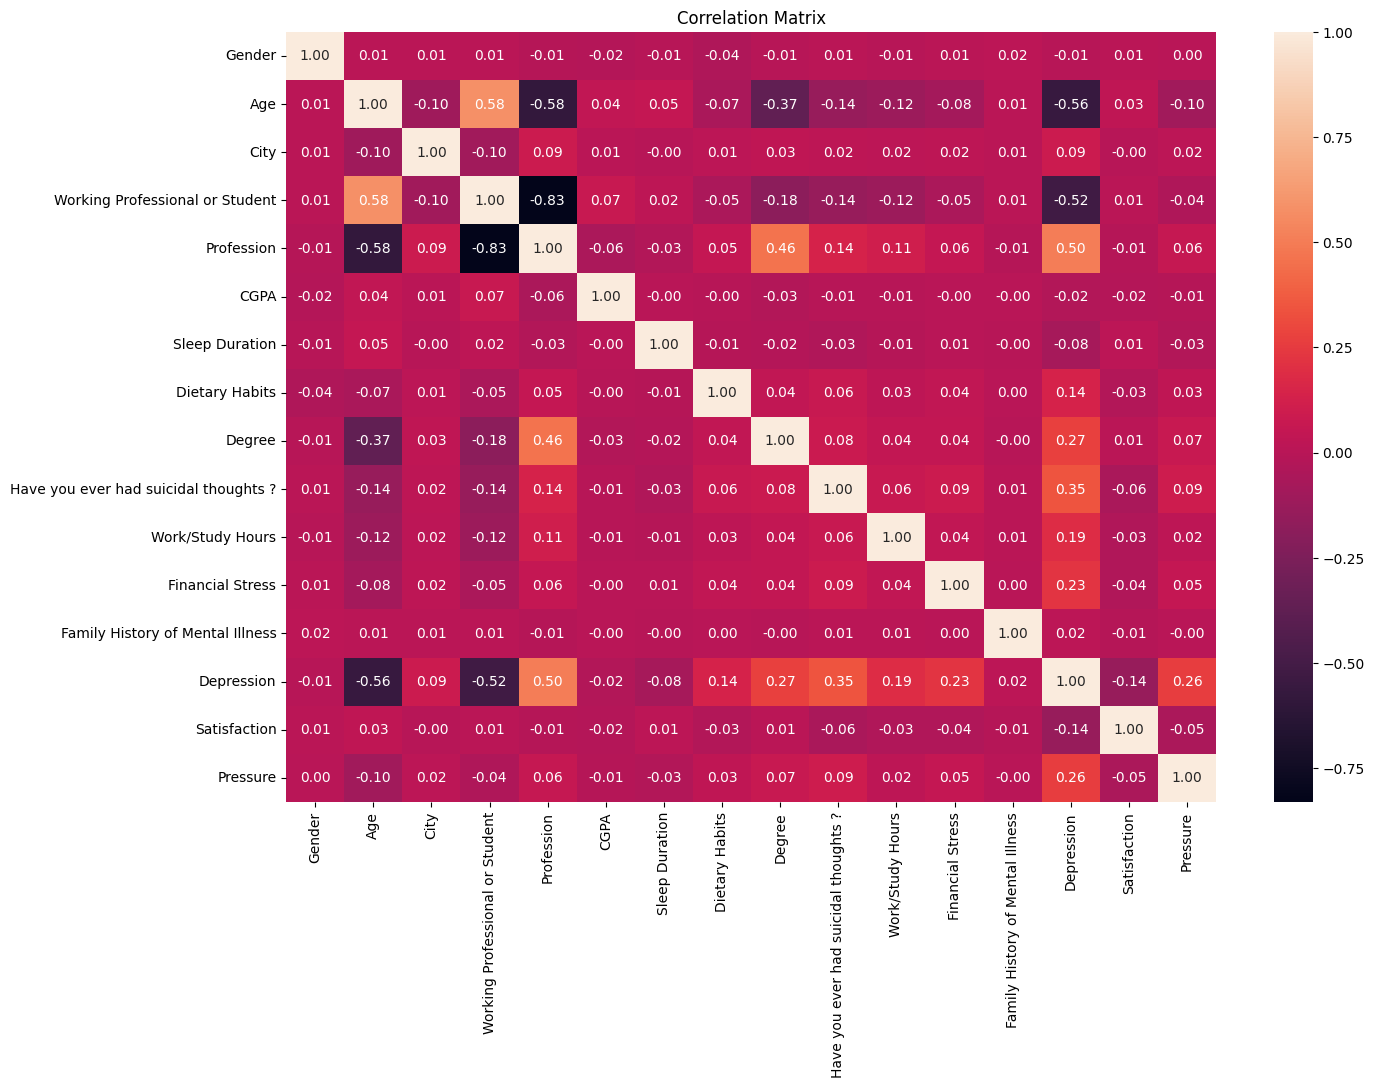

In [54]:
plt.figure(figsize=(15,10))
sns.heatmap(train_final.corr(), annot=True,fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Model Training

In [55]:
y = train_final['Depression']
X = train_final.drop(['Depression'],axis=1)

In [56]:
X_resampled = X
y_resampled = y

In [57]:
X_original = original_final.drop('Depression', axis=1)
y_original = original_final['Depression']

In [58]:
%%capture
!pip install optuna

In [59]:
from sklearn.model_selection import StratifiedKFold, KFold
from lightgbm import LGBMClassifier
import optuna
import os

# Configure Optuna logger
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [60]:
# Define StratifiedKFold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [61]:
'''
"""RUN THIS TO GET BEST HYPERPARAMETERS"""

def lgbm_objective(trial):
    
     params = {
         'num_leaves': trial.suggest_int('num_leaves', 31, 255),
         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'max_depth': trial.suggest_int('max_depth', 3, 10),
         'objective': 'binary',
         'metric': 'binary_error',
     }

     cv_scores = []
     for train_index, val_index in kf.split(X_resampled,y_resampled):
         # Use .iloc to index by integer positions for rows
         X_train_fold, X_val_fold = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
         y_train_fold, y_val_fold = y_resampled.iloc[train_index], y_resampled.iloc[val_index]
        
         model = LGBMClassifier(**params)
         model.fit(X_train_fold, y_train_fold)
        
         score = model.score(X_val_fold, y_val_fold)  # You can use other evaluation metrics here
         cv_scores.append(score)

     mean_cv_score = np.mean(cv_scores)
     return mean_cv_score

# Create an Optuna study and optimize hyperparameters
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=100)

# Get best LightGBM parameters
best_lgbm_params = lgbm_study.best_params
print(best_lgbm_params)
'''

'\n"""RUN THIS TO GET BEST HYPERPARAMETERS"""\n\ndef lgbm_objective(trial):\n    \n     params = {\n         \'num_leaves\': trial.suggest_int(\'num_leaves\', 31, 255),\n         \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 1e-5, 1e-1),\n         \'feature_fraction\': trial.suggest_uniform(\'feature_fraction\', 0.4, 1.0),\n         \'bagging_fraction\': trial.suggest_uniform(\'bagging_fraction\', 0.4, 1.0),\n        \'bagging_freq\': trial.suggest_int(\'bagging_freq\', 1, 7),\n         \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n         \'objective\': \'binary\',\n         \'metric\': \'binary_error\',\n     }\n\n     cv_scores = []\n     for train_index, val_index in kf.split(X_resampled,y_resampled):\n         # Use .iloc to index by integer positions for rows\n         X_train_fold, X_val_fold = X_resampled.iloc[train_index], X_resampled.iloc[val_index]\n         y_train_fold, y_val_fold = y_resampled.iloc[train_index], y_resampled.iloc[val_index]\n  

In [62]:
lgbm_params = {'num_leaves': 54,
          'learning_rate': 0.09108502659377889,
          'feature_fraction': 0.4038156024412934, 
          'bagging_fraction': 0.6496718560163661, 
          'bagging_freq': 2, 
          'max_depth': 6}

In [63]:
cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X, y)
scores = []
test_preds = []
# X_test_pool = Pool(test_final)
for i, (train_idx, val_idx) in enumerate(cv_splits):
    
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    #concatination of original data when after split of validation data
    X_trainC = pd.concat([X_train_fold,X_original],ignore_index = True)
    y_trainC = pd.concat([y_train_fold,y_original], ignore_index = True)
    
    model = LGBMClassifier(**lgbm_params,verbose = -1)
    model.fit(X_trainC,y_trainC)
    
    val_pred = model.predict(X_val_fold)
    score = accuracy_score(y_val_fold, val_pred)
    scores.append(score)
    
    test_pred = model.predict_proba(test_final)[:, 1]
    test_preds.append(test_pred)
    print(f'Fold {i + 1} accuracy_score: {score}')
print(f'Cross-validated accuracy_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max accuracy_score score: {np.max(scores):.6f}')
print(f'Min accuracy_score score: {np.min(scores):.6f}')

Fold 1 accuracy_score: 0.9396588486140725
Fold 2 accuracy_score: 0.9372778962331201
Fold 3 accuracy_score: 0.9402985074626866
Fold 4 accuracy_score: 0.9389481165600568
Fold 5 accuracy_score: 0.937953091684435
Cross-validated accuracy_score: 0.939 +/- 0.001
Max accuracy_score score: 0.940299
Min accuracy_score score: 0.937278


In [64]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
sample_submission['Depression'] = np.round(np.mean(test_preds, axis=0))
sample_submission.head(20)

,id,Depression
0,140700,0.0
1,140701,0.0
2,140702,0.0
3,140703,1.0
4,140704,0.0
5,140705,0.0
6,140706,0.0
7,140707,0.0
8,140708,0.0
9,140709,1.0


In [65]:
sample_submission.to_csv('submission.csv', index=False)
print("File Saved!")

File Saved!
